In [1]:
import numpy as np
import random
from IPython.display import clear_output
from collections import deque

import matplotlib.pyplot as plt
import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:

env_name = 'LunarLander-v2'
# env_name = 'CarRacing-v0'
env = gym.make(env_name)

print('Number of states: {}'.format(env.observation_space.shape))
print('Number of actions: {}'.format(env.action_space.n))

Number of states: (8,)
Number of actions: 4


In [3]:
class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)  #number of experiences to store 
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [4]:
#Modified Source: https://rubikscode.net/2019/07/08/deep-q-learning-with-python-and-tensorflow-2-0/

class DQAgent: 
    def __init__(self, gamma, epsilon, eps_min, environment, optimizer, input_dims, fc1, fc2):
        #initialize state and action space based on environment object
        self.state_size = env.observation_space.shape[0]
        self.action_size = environment.action_space.n
        self.optimizer = optimizer
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        
        #initilize the replay memory
        self.replay_buffer = ReplayBuffer(maxlen=5000)   
      
        #build the Q Network and Target network
        self.q_network = self.build_dqn(self.action_size, input_dims, fc1, fc2)
        self.target_network = self.build_dqn(self.action_size, input_dims, fc1, fc2)
        
        #align the weights
        self.align_target_model()  #this is causing a problem because it is getting called too soon
        
    #append experience to experience memory        
    def store(self, state, action, reward, next_state, terminated):
        if terminated:
            self.epsilon = max(eps_min, 0.99 * self.epsilon)
        self.replay_buffer.add((state, action, reward, next_state, (1-int(terminated))))


    #Build deep q network 
    def build_dqn(self, n_actions, input_dims, fc1, fc2): #fc = fully connected dimensions
        model = keras.Sequential([
            keras.layers.Dense(fc1, input_shape = input_dims, activation='relu'), 
            keras.layers.Dense(fc2, activation='relu'), 
            keras.layers.Dense(n_actions, activation=None), #output layer, n_actions is number of available actions
        ])

        model.compile(loss='mse', optimizer = self.optimizer)
        return model

    def align_target_model(self):
        self.target_network.set_weights(
            self.q_network.get_weights()) #passes q_network weights to target model

    #exploration vs. exploitation with probability of epsilon
    def act(self, state):        
        state = np.array([state])
        q_values = self.q_network.predict(state)
        action_greedy = np.argmax(q_values[0])
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.epsilon else action_greedy

        return action


    #take random samples from experience replay memory and train the q_network
    def retrain(self, batch_size):

        states, actions,rewards, next_states,terms = self.replay_buffer.sample(batch_size)
    
        states = np.array(states)
        next_states = np.array(next_states)
        
        q_network = self.q_network.predict(states)
        q_next = self.q_network.predict(next_states)

        q_target = np.copy(q_network)
        batch_index = np.arange(len(q_target), dtype=np.int32)

        
        q_target[batch_index, actions] = rewards + self.gamma * np.ndarray.max(q_next, axis=1) * terms
        
        self.q_network.train_on_batch(states,q_target)
                
        

In [5]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
env = gym.wrappers.Monitor(env, "./vid", video_callable=lambda episode_id: episode_id%10==0)
'''
Hyperparameters are all here so I can tune them all in the same spot

Learning rate
gamma
epsilon
optimizer
Dense layer shape
'''
lr = 0.001
gam = 0.99
eps = 1.0
eps_min = 0.01
opt = Adam(learning_rate=lr)
dims = env.observation_space.shape
layer_1 = 64
layer_2 = 64

agent = DQAgent(gamma = gam, epsilon = eps, eps_min = eps_min, environment = env, optimizer = opt, 
                input_dims = dims, fc1 = layer_1, fc2 = layer_2)


In [6]:
batch_size = 64
num_episodes = 300

total_rewards = []
for e in range(num_episodes): 
    #reset the environment to get random initial state
    state = env.reset()
   
    total_reward = 0
    terminated = False
    
    while not terminated:
        env.render()
        action = agent.act(state)      

        # take action 
        next_state, reward, terminated, info = env.step(action)

        # train = store experience in buffer, get samples
        total_reward += reward
        
        agent.store(state, action, reward, next_state, terminated) #add experience to buffer         
        state = next_state
        agent.retrain(batch_size)
    total_rewards.append(total_reward)
        
    print("Episode: {}, total reward: {}, epsilon: {}".format(e,total_reward, agent.epsilon))

    
    
x = [i for i in range(num_episodes)]

env.close()



Episode: 0, total reward: -143.6031547666359, epsilon: 0.99
Episode: 1, total reward: -261.0653915368299, epsilon: 0.9801
Episode: 2, total reward: -248.26381099173358, epsilon: 0.9702989999999999
Episode: 3, total reward: -255.13863519697026, epsilon: 0.96059601
Episode: 4, total reward: -157.5240027299919, epsilon: 0.9509900498999999
Episode: 5, total reward: -120.00223362081795, epsilon: 0.9414801494009999
Episode: 6, total reward: -6.931918644972583, epsilon: 0.9320653479069899
Episode: 7, total reward: -529.6516733245303, epsilon: 0.92274469442792
Episode: 8, total reward: -37.61576061595905, epsilon: 0.9135172474836407
Episode: 9, total reward: -167.6971716353994, epsilon: 0.9043820750088043
Episode: 10, total reward: -249.40421743898403, epsilon: 0.8953382542587163
Episode: 11, total reward: -118.8817262814494, epsilon: 0.8863848717161291
Episode: 12, total reward: -75.03912769727961, epsilon: 0.8775210229989678
Episode: 13, total reward: -203.53484672917608, epsilon: 0.86874581

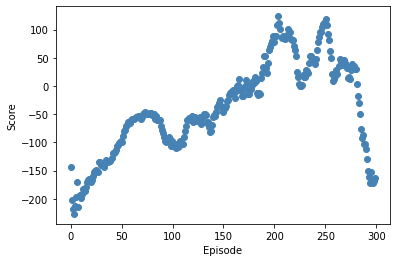

In [7]:
N = len(total_rewards)
running_avg = np.empty(N)
for t in range(N):
    running_avg[t] = np.mean(total_rewards[max(0, t-20):(t+1)])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.scatter(x, running_avg, color="steelblue");

In [8]:
env.close()